# Processing Time Series Data
In this Notebook, we will be processing time series data using different data sources.

Our Notebooks in CSMODEL are designed to be guided learning activities. To use them, simply go through the cells from top to bottom, following the directions along the way. If you find any unclear parts or mistakes in the Notebooks, email your instructor.

### What is a time series?
Time series data are samples observed in a chronological matter (across time), usually sampled at regular intervals. Some example applications in different fields are:

    1. Economics - This field usually look at the indicators of a country over time to see if the country is improving. Examples: GDP, unemployment, inflation, CPI, poverty.
    2. Finance - Daytraders that focus on technical analysis are actually looking at time series of the different stock prices to monitor trends and patterns to inform their decisions.
    3. Physics - Sine and cosine waves are heavily used in understanding sound and spread of soundwavse across time.

####  Some Samples

`DJIA 30 Stock Time Series` - Average stock price of specific companies included in the Dow Jones Index (used to assess market health).

![Stocks](https://miro.medium.com/max/1400/0*bCS3EWiVfLIZqwIW.gif)

`Voice sampled every .2 seconds` - Average frequency and amplitude of voice sampled at specific timeframes. Time series representation of voices are actually used to model voice recognition algorithms.


![Voice](https://miro.medium.com/max/700/1*80fnKgU_07EzqXWkJXZrQQ.png)

`Inflation Across Time Among the ASEAN Countries` - This shows the trend of inflation of different countries across time. Kinda shows how bad it is here in the PH as compared to other countries
![Inflation](https://assets.rappler.co/4A0970D12C774D96850FBCDB5D2707AA/img/86CDAB18C8304B6CB5DACBF8CA471CBC/Fig_1_aseaninf.png)

## Import
Import **`numpy`**, **`pandas`**, and the libraries to be used for time series analysis.

**`statsmodels`** provides different statistical models for data modeling.

The `tsa` (time series analysis) module is specifically provided for common techniques such as the `seasonal_decompose` for seasonality decomposition and `adfuller` for the Augmented Dickey-Fuller test.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data Processing

In most `csv` files and some datasets, date and time information are not necessarily encoded as a `datetime` object that can be processed by `pandas` or the computer easily. It is common for `pandas` to read in the date column as a `string` (object) first.

In this example, we'll be using a dataset from the [NYC Open Data Portal](https://data.cityofnewyork.us/Public-Safety/FDNY-Line-Of-Duty-Deaths/32y8-s55c) of the records of firefighter deaths.

In [2]:
fdny = pd.read_csv('data/FDNY_Line_Of_Duty_Deaths.csv')
fdny.head()

,Rank,Name,Unit,Date
0,FIREFIGHTER,ROBERT WINTRINGHAM,ENGINE 1,"AUGUST 24, 1865"
1,FIREFIGHTER,GEORGE BELL,ENGINE 8,"NOVEMBER 8, 1865"
2,FIREFIGHTER,THOMAS IRVIN,ENGINE 4,"DECEMBER 2, 1865"
3,FIREFIGHTER,DOMINICK SICOT,ENGINE 4,"DECEMBER 14, 1865"
4,FIREFIGHTER,PETER H. WALSH,ENGINE 5,"MAY 21, 1866"


In [3]:
fdny.dtypes

Rank    object
Name    object
Unit    object
Date    object
dtype: object

Looking at the data types above, we can see that the `Date` column is also treated as an `object` (string).

We need to first convert this to a `datetime` object in Python. For more information about the different features of the `datetime` object in Python, check out the [documentation](https://docs.python.org/3/library/datetime.html).

In `pandas`, there is a handy function to convert a string to datetime object called `pd.to_datetime()`

In [4]:
fdny['datetime'] = pd.to_datetime(fdny['Date'])
fdny.head()

,Rank,Name,Unit,Date,datetime
0,FIREFIGHTER,ROBERT WINTRINGHAM,ENGINE 1,"AUGUST 24, 1865",1865-08-24
1,FIREFIGHTER,GEORGE BELL,ENGINE 8,"NOVEMBER 8, 1865",1865-11-08
2,FIREFIGHTER,THOMAS IRVIN,ENGINE 4,"DECEMBER 2, 1865",1865-12-02
3,FIREFIGHTER,DOMINICK SICOT,ENGINE 4,"DECEMBER 14, 1865",1865-12-14
4,FIREFIGHTER,PETER H. WALSH,ENGINE 5,"MAY 21, 1866",1866-05-21


Notice that it was able to automatically detect the format of the string that the `Date` column was in. This only works well if your date format is consistent throughout the entire column.

However, you can definitely also pass an argument for non-conventional datetime formats ([format codes documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)).

### But wait, is this already a time series?

The answer is **NO!**. Right now, the data table above is just a record of firefighters and the date of their deaths.

A time series dataset requires a date column (✔ check!) and a quantitative value for each date. In this specific use case, we would first need to *count* how many firefighters died for each date.

In [5]:
fdny_death_series = pd.DataFrame(fdny['datetime'].value_counts())
fdny_death_series.columns = ['deaths']
fdny_death_series.head(10)

,deaths
2001-09-11,343
1966-10-17,12
1932-08-01,7
1956-04-04,6
1978-08-02,6
1962-10-26,6
1906-03-26,4
2001-06-17,3
1960-11-18,3
1900-03-24,3


With `value_counts()`, we can easily count per date occurrence in the series.

Looking at the table above, we can see that the dates are not sorted and it currently does have some missing dates in between.

If we wanted to have a **complete** series, we can generate a date range from the earliest date to the last date in the data using `pd.date_range()`

In [6]:
fdny_death_series.index.min()

Timestamp('1865-08-24 00:00:00')

In [7]:
fdny_death_series.index.max()

Timestamp('2012-04-16 00:00:00')

#### Creating the date range

Using the earliest and latest date in the dataset, we can generate the daily range.

In [8]:
date_range = pd.date_range(start=fdny_death_series.index.min(), 
                           end=fdny_death_series.index.max(),
                           freq='D'
                          )
date_range

DatetimeIndex(['1865-08-24', '1865-08-25', '1865-08-26', '1865-08-27',
               '1865-08-28', '1865-08-29', '1865-08-30', '1865-08-31',
               '1865-09-01', '1865-09-02',
               ...
               '2012-04-07', '2012-04-08', '2012-04-09', '2012-04-10',
               '2012-04-11', '2012-04-12', '2012-04-13', '2012-04-14',
               '2012-04-15', '2012-04-16'],
              dtype='datetime64[ns]', length=53562, freq='D')

The above `date_range` variable currently is a `DateTimeIndex` object which we can use to create a new `DataFrame` with null values for the dates that have no deaths.

In [9]:
fdny_complete_series = fdny_death_series.merge(pd.DataFrame(index=date_range), 
                                               right_index=True, 
                                               left_index=True, 
                                               how='outer')

The above `DataFrame` is now a complete time series (with a lot of missing values) from 1865 to 2012.

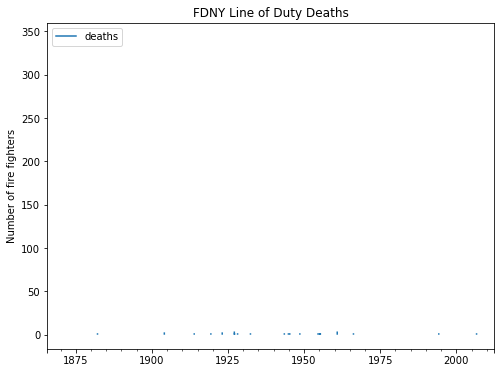

In [10]:
ax = fdny_complete_series.plot(figsize=(8, 6))
ax.set_title('FDNY Line of Duty Deaths')
ax.set_ylabel('Number of fire fighters');

Looking at the chart above, because of the `NaN`s, the line series is broken.

Since the days with `NaN`s actually represent "no deaths", we can fill the null values with 0.

In [11]:
fdny_complete_series.fillna(0, inplace=True)

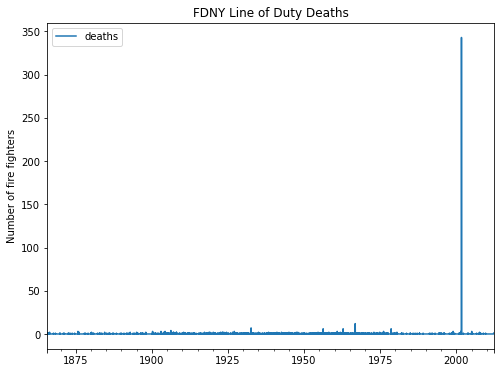

In [12]:
ax = fdny_complete_series.plot(figsize=(8, 6))
ax.set_title('FDNY Line of Duty Deaths')
ax.set_ylabel('Number of fire fighters');

Visualizing this now, we can see the different points in which there are deaths. 

However, notice the spike? That's what we call an outlier or in time series terminology, it's an event!

#### Thresholding

A quick and easy way to find outliers or events in a time series would be to use the thresholding method. 

By simply using the mean and standard deviation of the series, we can get an upper and lower threshold if necessary.

Since the lower threshold for this dataset would be negative, it doesn't seem to make sense to compute for it now.

*Note that I'm using the original `fdny_death_series` dataset here since filling in with zero values for other dates will also affect our mean and standard deviation!*

In [13]:
upper_threshold = float(fdny_death_series.mean() + (3 * fdny_death_series.std()))
print(upper_threshold)

39.52669938756396


In [14]:
fdny_death_series[fdny_death_series['deaths'] >= upper_threshold]

,deaths
2001-09-11,343


Looking at this date, we can more or less conclude that the 9/11 bombing was the major event that caused quite a number of deaths in the FDNY. 

By removing the data point temporarily in a copy of the dataframe, we can inspect further the dataset to see if there are any more "outliers" or special events.

In [15]:
fdny_death_copy = fdny_death_series.copy()
fdny_death_copy.loc['2001-09-11'] = np.NaN

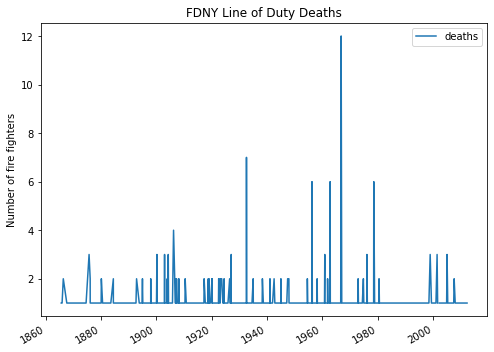

In [16]:
ax = fdny_death_copy.plot(figsize=(8,6))
ax.set_title('FDNY Line of Duty Deaths')
ax.set_ylabel('Number of fire fighters');

In [17]:
upper_complete = float(fdny_complete_series.mean() + (3 * fdny_complete_series.std()))
print(upper_complete)

4.4909362470987935


In [18]:
fdny_complete_series[fdny_complete_series['deaths'] >= upper_complete]

,deaths
1932-08-01,7.0
1956-04-04,6.0
1962-10-26,6.0
1966-10-17,12.0
1978-08-02,6.0
2001-09-11,343.0


Looking at the filled in `fdny_complete_series`, we can see that some of the outlier events were already picked out for us.

## Aggregation and Granularity

Granularity in panel data talks about the level of grouping of the samples. Usually we group them to be able to analyze samples a larger scale. Similarly, we can also group time series data depending on the level of **temporality** that you would want to check. The usual level of grouping for time is : 

`Seconds` -> `Minutes` -> `Hours` -> `Days` -> `Weeks` -> `Months` -> `Years` -> `Decades` -> `Centuries`

Example: 

![Stocks](http://kourentzes.com/forecasting/wp-content/uploads/2014/05/fors1.fig1_.png)

In [19]:
ny_aqi = pd.read_csv('data/ny_aqi_daily_1980_to_2021.csv')
ny_aqi['Date'] = pd.to_datetime(ny_aqi['Date'])
ny_aqi.head()

,State Name,Date,AQI,Category,Defining Parameter,Latitude,Longitude,County Name
0,New York,2021-01-01,36,Good,PM2.5,42.640931,-73.756511,Albany
1,New York,2021-01-02,28,Good,Ozone,42.640931,-73.756511,Albany
2,New York,2021-01-03,38,Good,PM2.5,42.640931,-73.756511,Albany
3,New York,2021-01-04,56,Moderate,PM2.5,42.640931,-73.756511,Albany
4,New York,2021-01-05,39,Good,PM2.5,42.640931,-73.756511,Albany


In [20]:
ny_aqi['Defining Parameter'].unique()

array(['PM2.5', 'Ozone', 'NO2', 'CO', 'SO2', 'PM10'], dtype=object)

### Regular aggregation
Let's just take a look at the PM 2.5 parameter and let's get the average per day.

In [21]:
pm25 = ny_aqi[ny_aqi['Defining Parameter'] == 'PM2.5'].groupby(pd.Grouper(key='Date', freq='D'))['AQI'].mean()
pm25.head()

Date
1999-07-01     68.000000
1999-07-02     71.125000
1999-07-03           NaN
1999-07-04    110.000000
1999-07-05     85.142857
Freq: D, Name: AQI, dtype: float64

In [22]:
upper = pm25.mean() + (3 * pm25.std())
lower = pm25.mean() - (3 * pm25.std())

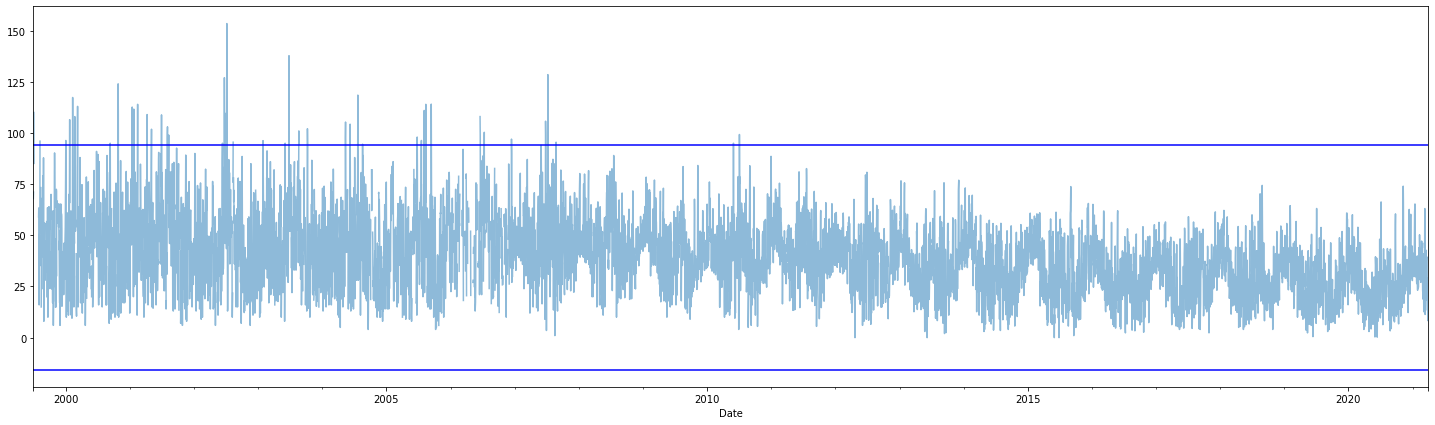

In [23]:
ax = pm25.plot(figsize=(25, 7), alpha=0.5)
ax.axhline(upper, color='b')
ax.axhline(lower, color='b')

### Regular Aggregation

Time series can be aggregated based on their different components (daily, weekly, monthly, yearly, etc).

However, this type of aggregation will lead to a not-so-smooth time series since it does not account for the previous time periods, only by a boundary (i.e. Monday to Sunday for weekly, day 1 to day 28/29/30/31 for monthly).

In [24]:
daily_agg = ny_aqi.groupby(pd.Grouper(key='Date', freq='D'))['AQI'].mean().reset_index()
weekly_agg = ny_aqi.groupby(pd.Grouper(key='Date', freq='W'))['AQI'].mean().reset_index()
monthstart_agg = ny_aqi.groupby(pd.Grouper(key='Date', freq='MS'))['AQI'].mean().reset_index()
monthend_agg = ny_aqi.groupby(pd.Grouper(key='Date', freq='M'))['AQI'].mean().reset_index()

In [25]:
daily_agg.head()

,Date,AQI
0,1980-01-01,80.588235
1,1980-01-02,72.882353
2,1980-01-03,49.058824
3,1980-01-04,66.588235
4,1980-01-05,46.823529


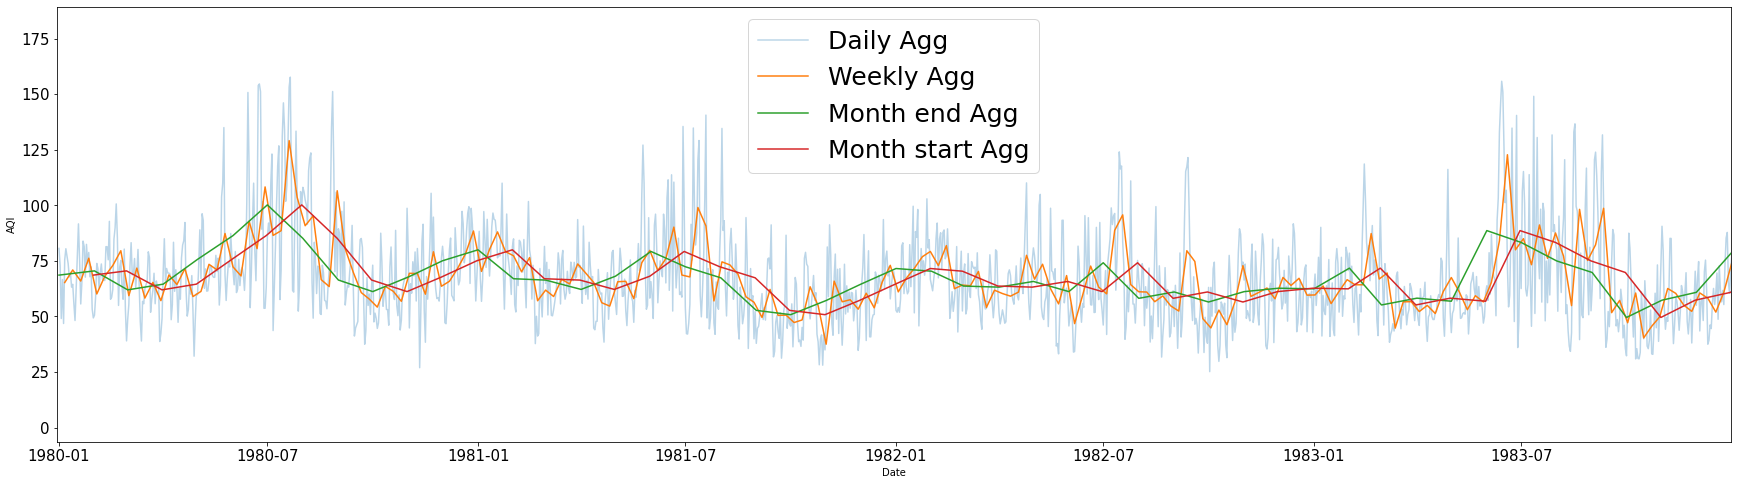

In [26]:
plt.figure(figsize=(30,8))

#Plotting the Grouped Data with different Granularity
plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Daily Agg', alpha=0.3)
plt.plot(weekly_agg['Date'], weekly_agg['AQI'], label='Weekly Agg',)
plt.plot(monthstart_agg['Date'], monthstart_agg['AQI'], label='Month end Agg')
plt.plot(monthend_agg['Date'], monthend_agg['AQI'], label = 'Month start Agg')

plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('1979-12-30'), pd.to_datetime('1983-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

Looking at the time series above, you can see that the aggregated time series have sharp edges depending on when you start and end.

## Aggregation via a Moving Window

But regardless, notice that as we increase the granularity of the grouping, we were able to "smoothen" the graph. This is because time series aggregation will account for the the variation observed in the granular data (similar to when we group samples to specific categories to get descriptive statistics). 

One flaw in the usual aggregation method is it only accounts for the data at the specific window that we are aggregating (i.e. if we aggregate by month, the calculation will not factor in the previous months). It is in the nature of timeseries that datapoints are **autocorrelated** meaning the past is somehow related with the present values. This means that whatever the past values are in the series, it may have meaningful relationship with the present values that we **SHOULD** account for. Moving or Rolling averages were created to be able to account for this "flaw" in the usual timeseries aggregation method. 

Procedurally, this is what happens under the hood : 

![Moving average info](https://media.geeksforgeeks.org/wp-content/uploads/20211116101813/Capture.PNG)

We can implement it in python using the code block below: 

In [27]:
daily_agg['7D_MA'] = daily_agg['AQI'].rolling(window=7).mean()
daily_agg['7D_STD'] = daily_agg['AQI'].rolling(window=7).std()

In [28]:
daily_agg.head(14)

,Date,AQI,7D_MA,7D_STD
0,1980-01-01,80.588235,NaN,NaN
1,1980-01-02,72.882353,NaN,NaN
2,1980-01-03,49.058824,NaN,NaN
3,1980-01-04,66.588235,NaN,NaN
4,1980-01-05,46.823529,NaN,NaN
5,1980-01-06,75.470588,NaN,NaN
6,1980-01-07,80.444444,67.408030,14.140521
7,1980-01-08,77.166667,66.919234,13.659959
8,1980-01-09,73.764706,67.045285,13.728057
9,1980-01-10,67.722222,69.711485,11.239383


#### Benefits and downside of using Moving Averages

Benefits:
* Information from the Past - this method accounts for the possible relationship of past values with the present
* Smoothness - allows for the series to be smoothened making trend more visible (higher window, the smoother the series will be)
* Can be used for forecasting - one of the most intuitive and classical model
    
Downside:
* Loss of data

#### Challenge: Try getting the 30-day moving average of the NY AQI

In [29]:
# your code here
daily_agg['30D_MA'] = daily_agg['AQI'].rolling(window=30).mean()
daily_agg['30D_STD'] = daily_agg['AQI'].rolling(window=30).std()

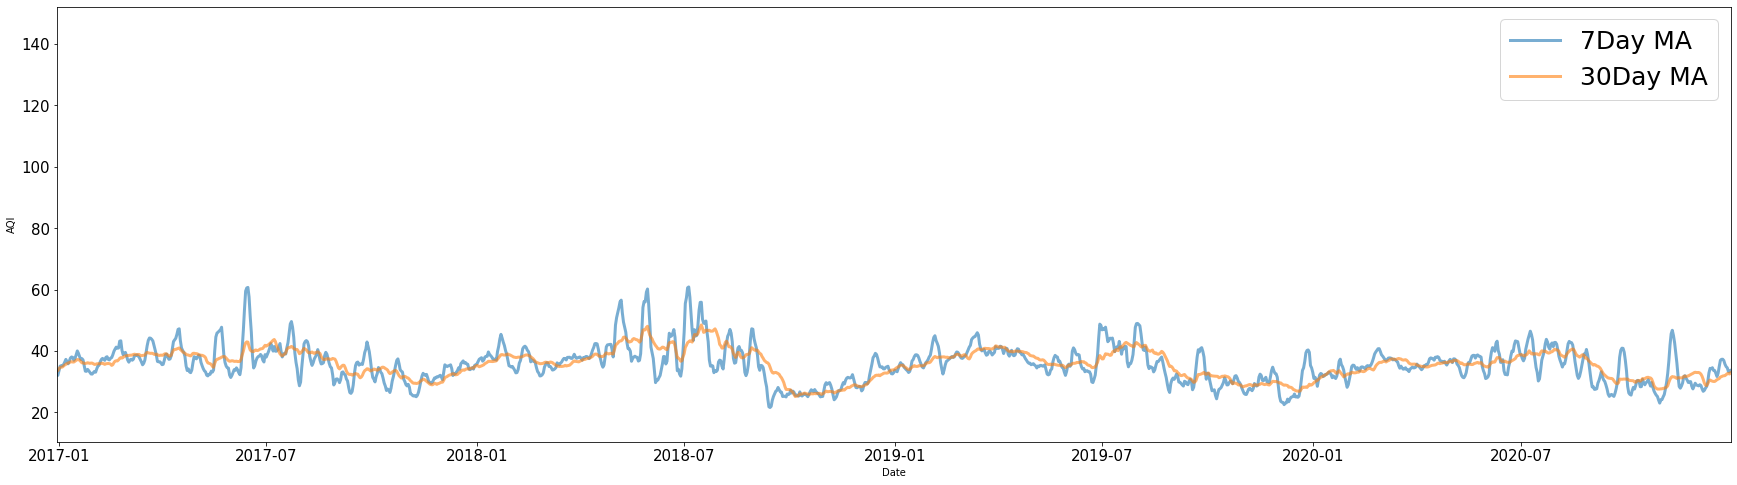

In [30]:
# Smoothness
plt.figure(figsize=(30,8))

# plt.plot(weekly_agg['Date'], weekly_agg['AQI'], label='weekly', alpha=0.3, lw=4)
# plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Original', alpha=0.4, lw=3)

#Plotting the 7Day MA
plt.plot(daily_agg['Date'], daily_agg['7D_MA'], label='7Day MA', alpha=0.6, lw=3)

#Plotting the 30Day MA
# uncomment the line to show the 30 day
plt.plot(daily_agg['Date'], daily_agg['30D_MA'], label='30Day MA', alpha=0.6, lw=3)

plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('2016-12-30'), pd.to_datetime('2020-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

## Major Components of Observed Time Series

Time series have components that we can look at to further understand the behavior of our data.

`Trend` - long term slope and direction of the timeseries. Question : How long is long? and what if there are shifts in trend?

`Cycle` - pattern in data that is observed but is not chunked within a specific timeframe (i.e. repeat during x number of weeks/days, but boom and bust is observable)

`Seasonality` - calendar based effects (seasons, definite scheduled holidays, tax periods)

`Irregularity` - term to capture stochasticity and randomness.


### Extracting the Major Components of a Series

Decomposition is a technique that can help us make sense of a time series. The result of decomposition will allow us to know what kind of "preprocessing" technique to apply to the series before we can move forward with more complex analysis and modelling.

The two most common ways to decompose a series are : 

    Additive Model - states that the series can be created by aggregating the estimated componantes together

    Multiplicative Model - states that the series can be created by multiplying the estimated componantes together

The code below will allow us to extract the important components of a timeseries

In [31]:
decompose_sample = ny_aqi.copy()

decompose_sample = decompose_sample.groupby(pd.Grouper(key='Date', freq='MS'))['AQI'].mean().reset_index()

decompose_sample = decompose_sample.set_index(pd.to_datetime(decompose_sample['Date'])).dropna()

decompose_sample.sort_index(inplace=True)

In [32]:
decompose_sample.head()

,Date,AQI
Date,,
1980-01-01,1980-01-01,68.582255
1980-02-01,1980-02-01,70.484009
1980-03-01,1980-03-01,61.944656
1980-04-01,1980-04-01,64.520080
1980-05-01,1980-05-01,75.667954


In [33]:
decompose_sample['Year'] = decompose_sample['Date'].dt.year
decompose_sample['Month'] = decompose_sample['Date'].dt.month

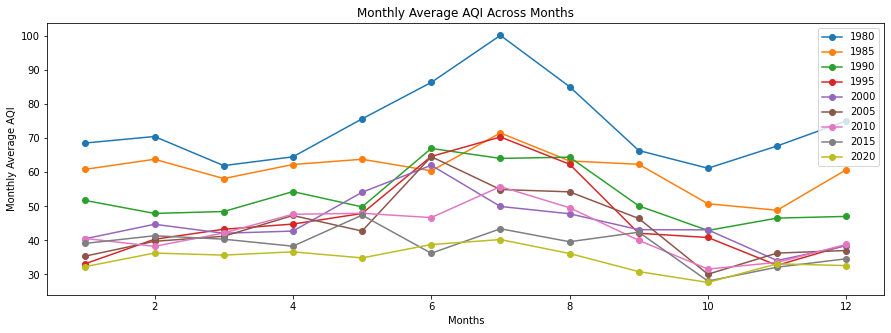

In [34]:
# Analyze first the original series 
# What is the trend? What months, on average is high?
# What to expect when we extract the components?
plt.figure(figsize=(15, 5))
for each in decompose_sample['Year'].unique()[0::5]:
    plt.plot(decompose_sample[decompose_sample['Year'] == each]['Month'],
             decompose_sample[decompose_sample['Year'] == each]['AQI'], marker='o', label=each)
    
    plt.legend(loc='best')
    plt.xlabel('Months')
    plt.ylabel('Monthly Average AQI')
    plt.title('Monthly Average AQI Across Months')

In [35]:
decompose_sample.head()

,Date,AQI,Year,Month
Date,,,,
1980-01-01,1980-01-01,68.582255,1980,1
1980-02-01,1980-02-01,70.484009,1980,2
1980-03-01,1980-03-01,61.944656,1980,3
1980-04-01,1980-04-01,64.520080,1980,4
1980-05-01,1980-05-01,75.667954,1980,5


In [36]:
decomp_result = seasonal_decompose(decompose_sample['AQI'], model='additive')

Text(0.5, 1.0, 'Residuals')

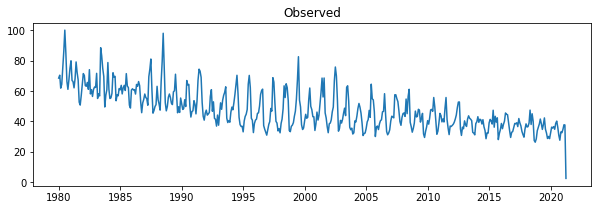

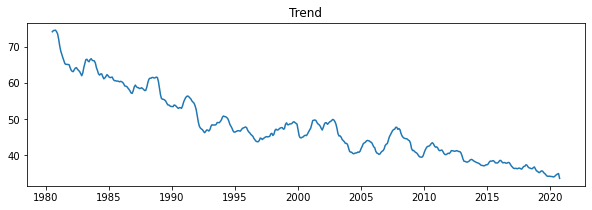

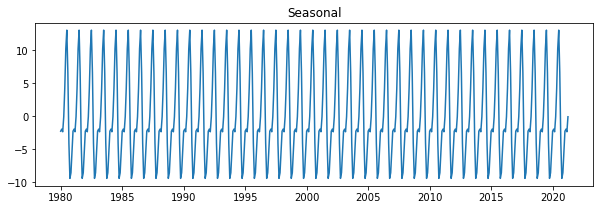

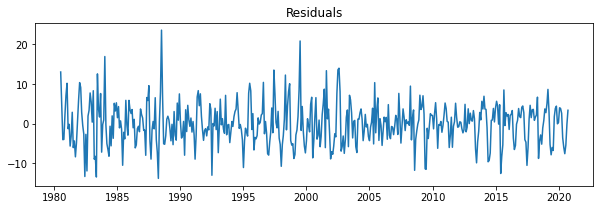

In [37]:
plt.figure(figsize=(10,3))
plt.plot(decomp_result.observed)
plt.title("Observed")
plt.figure(figsize=(10,3))
plt.plot(decomp_result.trend)
plt.title("Trend")
plt.figure(figsize=(10,3))
plt.plot(decomp_result.seasonal)
plt.title("Seasonal")
plt.figure(figsize=(10,3))
plt.plot(decomp_result.resid)
plt.title("Residuals")

### Monthly expectation

By analyzing the seasonality index extracted, we can somehow see the effect of certain months on the closing stock price. The graph below will give us an idea if a certain month has a positive / negative effect on the average closing price for that specific month.

In [38]:
seasonality_value = decomp_result.seasonal.reset_index()

In [39]:
seasonality_value

,Date,seasonal
0,1980-01-01,-2.257141
1,1980-02-01,-1.940027
2,1980-03-01,-2.339527
3,1980-04-01,-0.061777
4,1980-05-01,4.217691
...,...,...
491,2020-12-01,-5.564805
492,2021-01-01,-2.257141
493,2021-02-01,-1.940027
494,2021-03-01,-2.339527


In [40]:
seasonality_value['Month'] = seasonality_value['Date'].dt.month
seasonality_value = seasonality_value[['seasonal', 'Month']].drop_duplicates()

Here we can see that Microsoft's stock prices drop (on average) during January, March, April, May, October, November and December.

In [41]:
seasonality_value

,seasonal,Month
0,-2.257141,1
1,-1.940027,2
2,-2.339527,3
3,-0.061777,4
4,4.217691,5
5,10.260936,6
6,13.080953,7
7,6.629030,8
8,-4.048291,9
9,-9.412191,10


<BarContainer object of 8 artists>

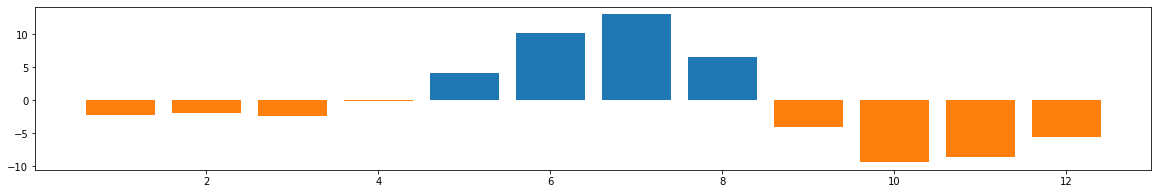

In [42]:
plt.figure(figsize=(20,3))

plt.bar(seasonality_value[seasonality_value['seasonal'] > 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] > 0]['seasonal'])


plt.bar(seasonality_value[seasonality_value['seasonal'] <= 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] <= 0]['seasonal'])

## Preprocessing Techniques Depend on Seasonality and Trend

The result that we get from decomposition will dictate what kind of preprocessing technique should be applied to the data. If you find that the data has seasonality / trend, we can use the table below to know how to impute for missing values. 

| Season      | Trend |Trendless |
| ----------- | ----------- |----------- |
| Seasonal      |Use __MEAN__ of the __adjacent__ years (same period)|Use __MEAN__ of __all__ available data |
| Non-Seasonal   |Use __MEAN__ of the __adjacent__ datapoints|Use __MEAN__ of __all__ available data  |


By following this table, we can more or less generate more accurate models.


## Stationarity and Autocorrelation


Some algorithms require stationarity of a series before it can be modelled. Non-stationary data, when used to train classical models (i.e. ARIMA) will result to autocorrelated residuals implying that the errors are severly increasing across time. This just means that the past values are dependent or **CORRELATED** with present and future values.  Residuals (Prediction - Actuals) that are not serially correlated is an assumption that must be passed before we can interpret ARIMA and other classical models. There are different preprocessing techniques that you can use to remove this relationship from the series.

A series that is stationary is defined to have the following properties :

    1) Trendless
    2) No predifined seasonality
    
    
![Stationarity](https://0megap0int.files.wordpress.com/2021/07/stationary.png)
  

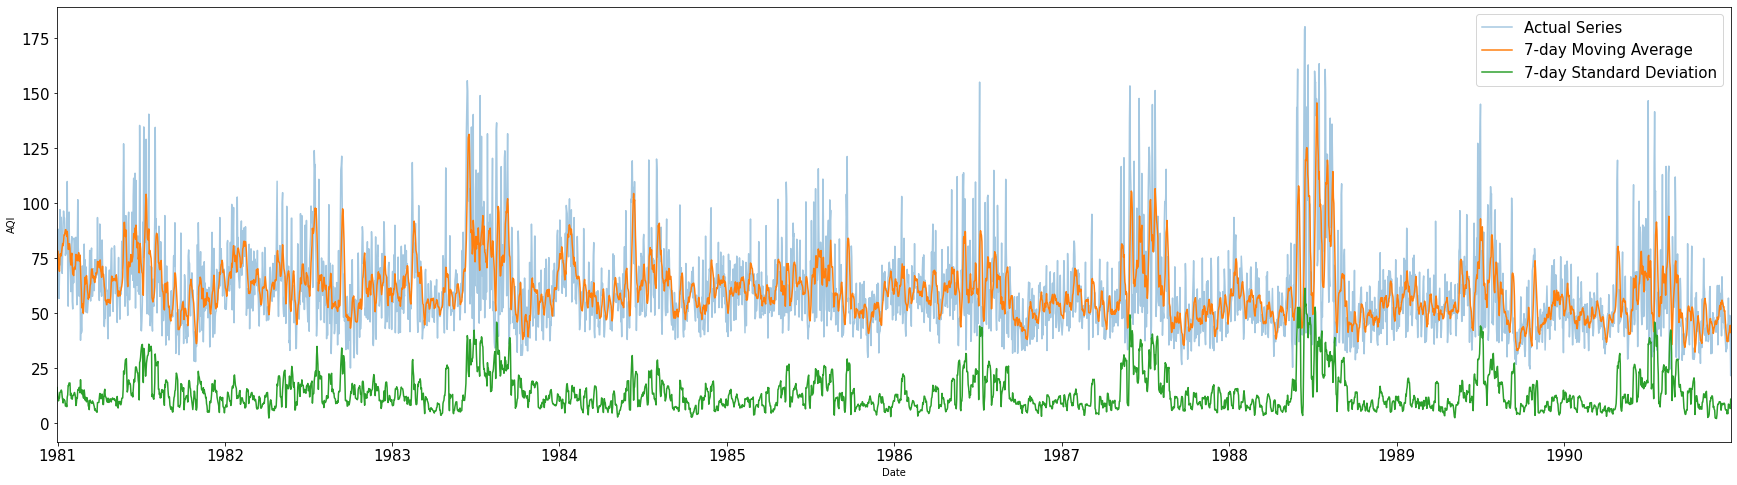

In [43]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Actual Series', alpha=0.4)
plt.plot(daily_agg['Date'], daily_agg['7D_MA'], label='7-day Moving Average')
plt.plot(daily_agg['Date'], daily_agg['7D_STD'], label='7-day Standard Deviation')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('1980-12-30'), pd.to_datetime('1990-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

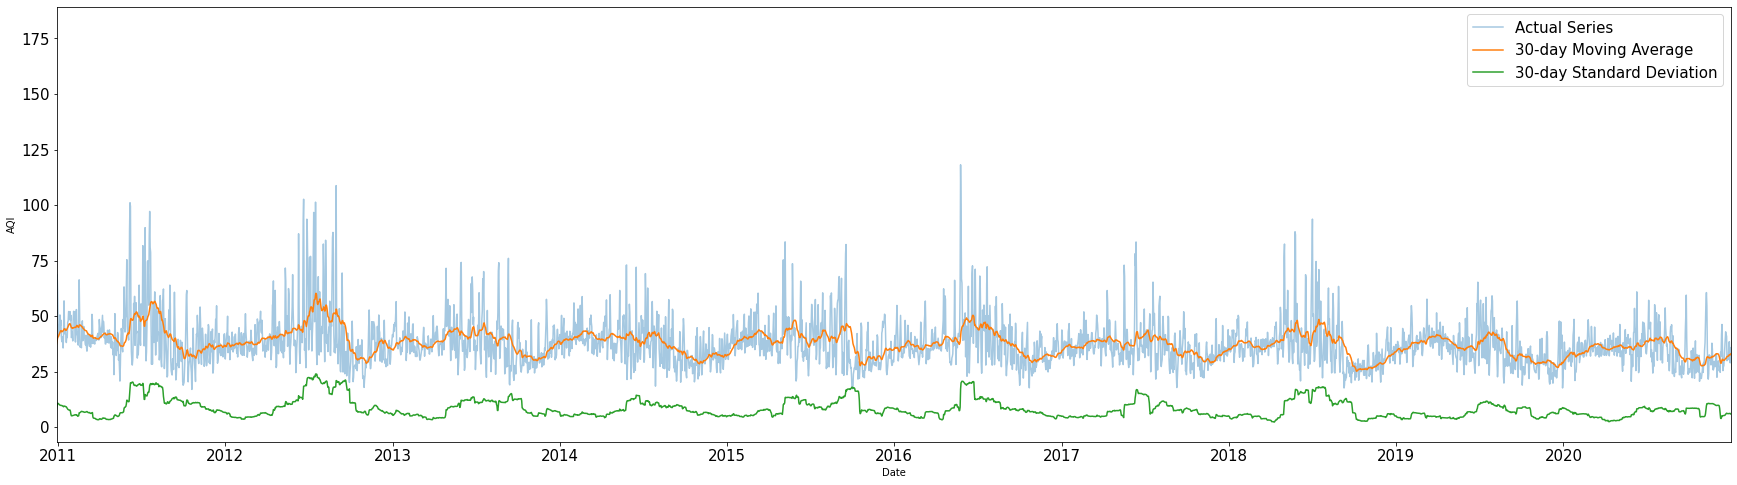

In [44]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Actual Series', alpha=0.4)
plt.plot(daily_agg['Date'], daily_agg['30D_MA'], label='30-day Moving Average')
plt.plot(daily_agg['Date'], daily_agg['30D_STD'], label='30-day Standard Deviation')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('2010-12-30'), pd.to_datetime('2020-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

### Differencing

You can difference the input series to be able to remedy for non-stationarity. Differencing is the direct subtraction of adjacent datapoints of timeperiod selected.

In [45]:
daily_agg['Differenced First Order'] = daily_agg['AQI'].diff()

In [46]:
daily_agg.head(10)

,Date,AQI,7D_MA,7D_STD,30D_MA,30D_STD,Differenced First Order
0,1980-01-01,80.588235,NaN,NaN,NaN,NaN,NaN
1,1980-01-02,72.882353,NaN,NaN,NaN,NaN,-7.705882
2,1980-01-03,49.058824,NaN,NaN,NaN,NaN,-23.823529
3,1980-01-04,66.588235,NaN,NaN,NaN,NaN,17.529412
4,1980-01-05,46.823529,NaN,NaN,NaN,NaN,-19.764706
5,1980-01-06,75.470588,NaN,NaN,NaN,NaN,28.647059
6,1980-01-07,80.444444,67.408030,14.140521,NaN,NaN,4.973856
7,1980-01-08,77.166667,66.919234,13.659959,NaN,NaN,-3.277778
8,1980-01-09,73.764706,67.045285,13.728057,NaN,NaN,-3.401961
9,1980-01-10,67.722222,69.711485,11.239383,NaN,NaN,-6.042484


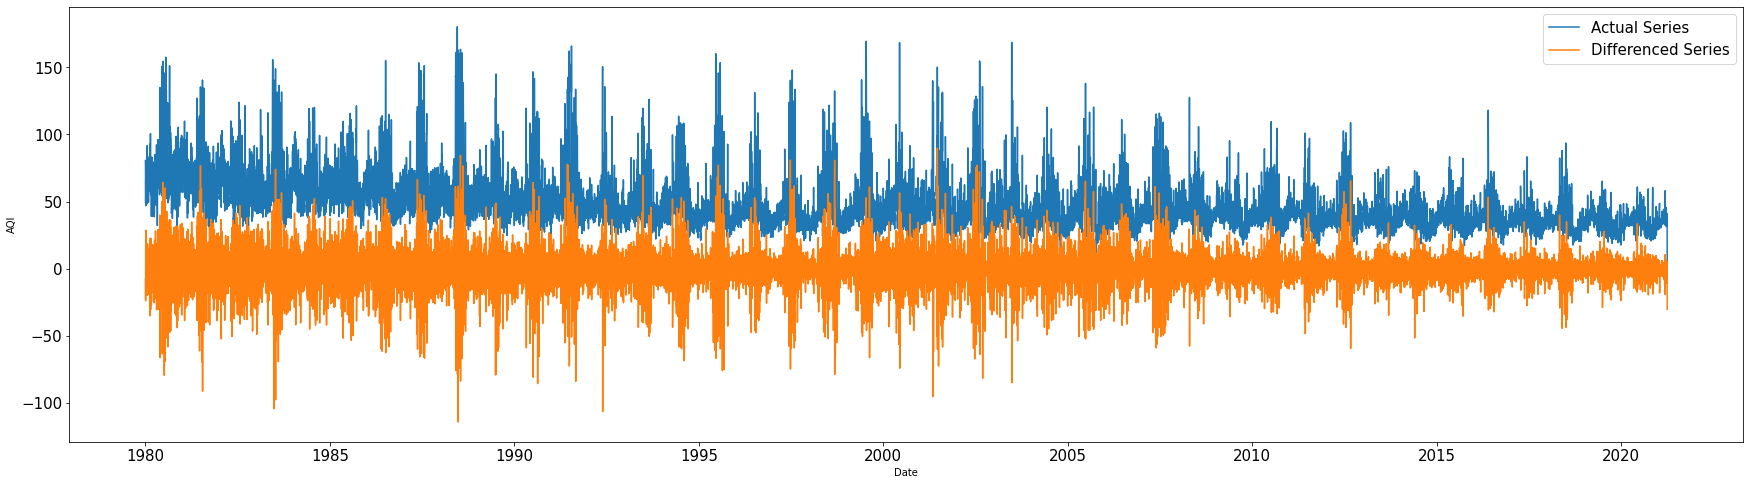

In [47]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Actual Series')
plt.plot(daily_agg['Date'], daily_agg['Differenced First Order'], label='Differenced Series')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim([pd.to_datetime('1979-12-30'), pd.to_datetime('1982-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

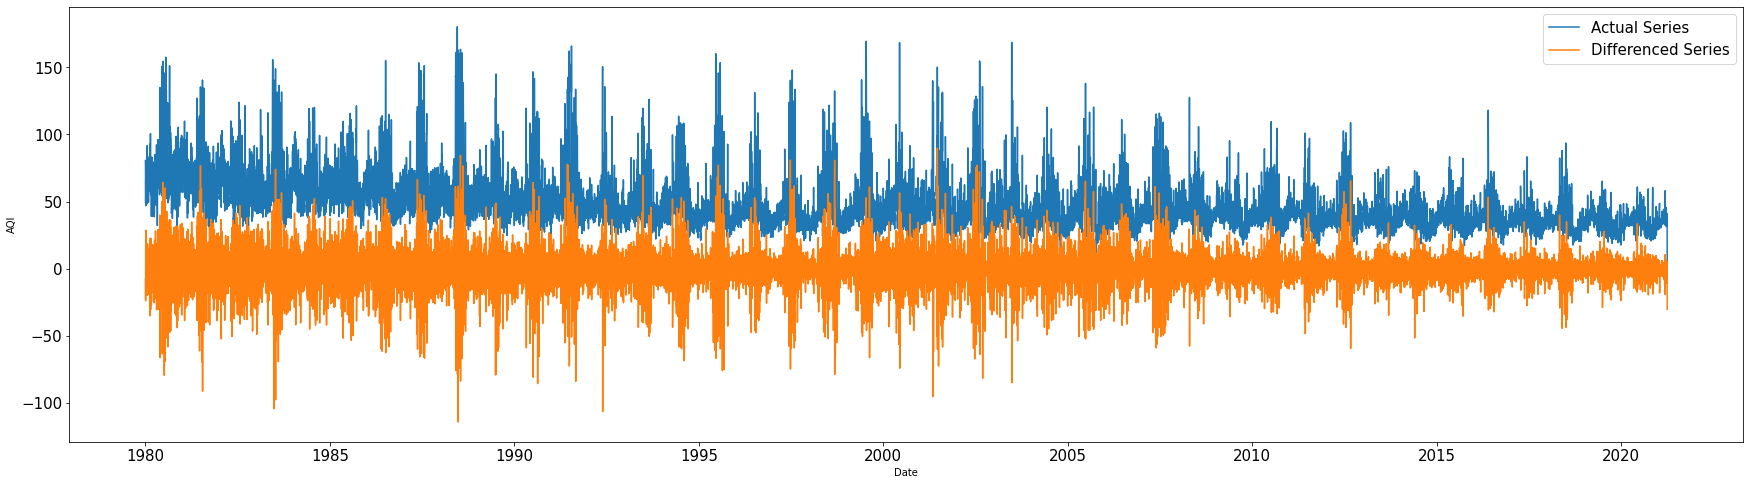

In [48]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['AQI'], label='Actual Series')
plt.plot(daily_agg['Date'], daily_agg['Differenced First Order'], label='Differenced Series')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim([pd.to_datetime('1979-12-30'), pd.to_datetime('1982-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

In [49]:
daily_agg['7D_Diff_MA'] = daily_agg['Differenced First Order'].rolling(window=7).mean()
daily_agg['7D_Diff_STD'] = daily_agg['Differenced First Order'].rolling(window=7).std()

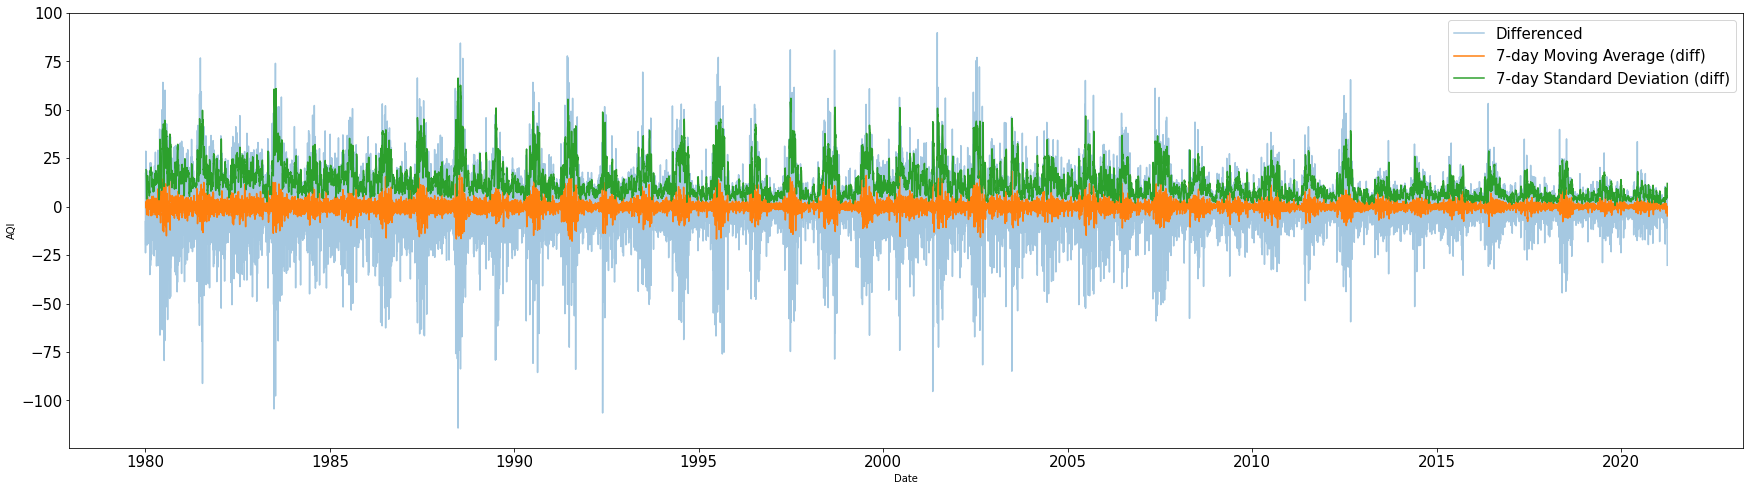

In [50]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['Differenced First Order'], label='Differenced', alpha=0.4)
plt.plot(daily_agg['Date'], daily_agg['7D_Diff_MA'], label='7-day Moving Average (diff)')
plt.plot(daily_agg['Date'], daily_agg['7D_Diff_STD'], label='7-day Standard Deviation (diff)')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim([pd.to_datetime('2010-12-30'), pd.to_datetime('2020-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

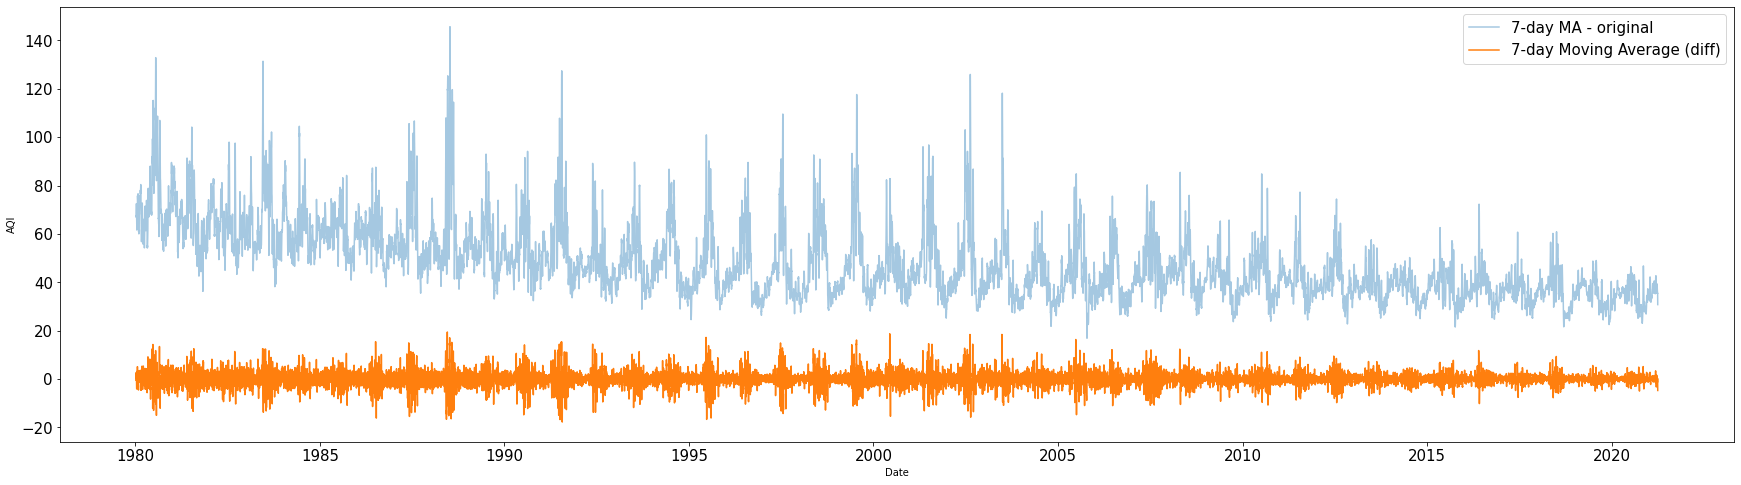

In [51]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['7D_MA'], label='7-day MA - original', alpha=0.4)
plt.plot(daily_agg['Date'], daily_agg['7D_Diff_MA'], label='7-day Moving Average (diff)')
# plt.plot(daily_agg['Date'], daily_agg['7D_Diff_STD'], label='7-day Standard Deviation (diff)')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim([pd.to_datetime('2010-12-30'), pd.to_datetime('2020-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

In [52]:
daily_agg['90D_MA'] = daily_agg['AQI'].rolling(window=90).mean()
daily_agg['90D_MA_D'] = daily_agg['Differenced First Order'].rolling(window=90).mean()

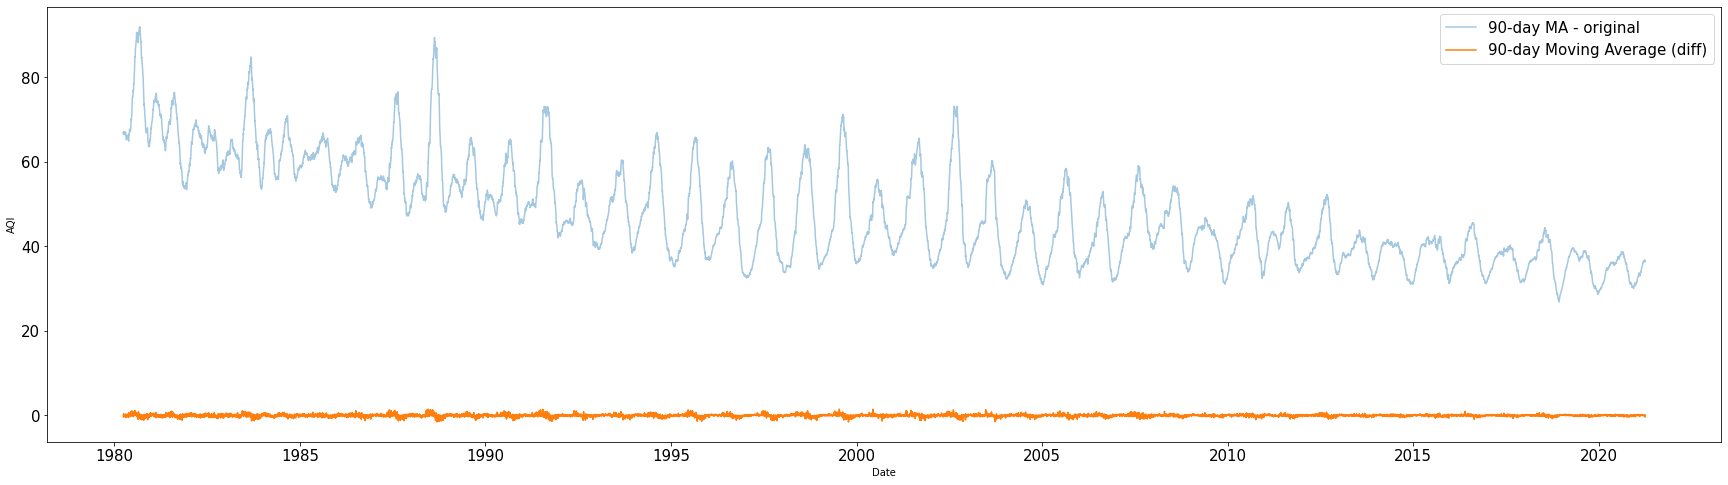

In [53]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(daily_agg['Date'], daily_agg['90D_MA'], label='90-day MA - original', alpha=0.4)
plt.plot(daily_agg['Date'], daily_agg['90D_MA_D'], label='90-day Moving Average (diff)')
# plt.plot(daily_agg['Date'], daily_agg['7D_Diff_STD'], label='7-day Standard Deviation (diff)')


plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim([pd.to_datetime('2010-12-30'), pd.to_datetime('2020-12-31')])
plt.xlabel('Date')
plt.ylabel('AQI');

### Augmented Dickey-Fuller test:

The formal way to check for stationarity is by using the [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).

Using the `statsmodels` function `adfuller` ([documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)), the hypothesis are as follows:

> The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.
>
> The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.
>
> The autolag option and maxlag for it are described in Greene.

When we say "there is a unit root", this means that the series is **not stationary**. In other words, the time series has some time-dependent structure and does not have constant variance over time.

In [54]:
result = adfuller(daily_agg['AQI'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.389442
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [55]:
result = adfuller(daily_agg['Differenced First Order'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -25.699233
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [56]:
result = adfuller(decomp_result.resid.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.002149
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


#### Conclusion
Since in both cases, the p-value is less than 0.05 (5% significance level), we can reject the null that the time series is **not stationary**. Therefore this time series is a stationary time series.

## Do it yourself!

Test it out on this dataset on airline passengers.

In [57]:
airline = pd.read_csv('data/airline-passengers.csv')
airline.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [58]:
airline.Month = pd.to_datetime(airline.Month)

### Get the 3-month moving average and standard deviation

In [59]:
# your code here

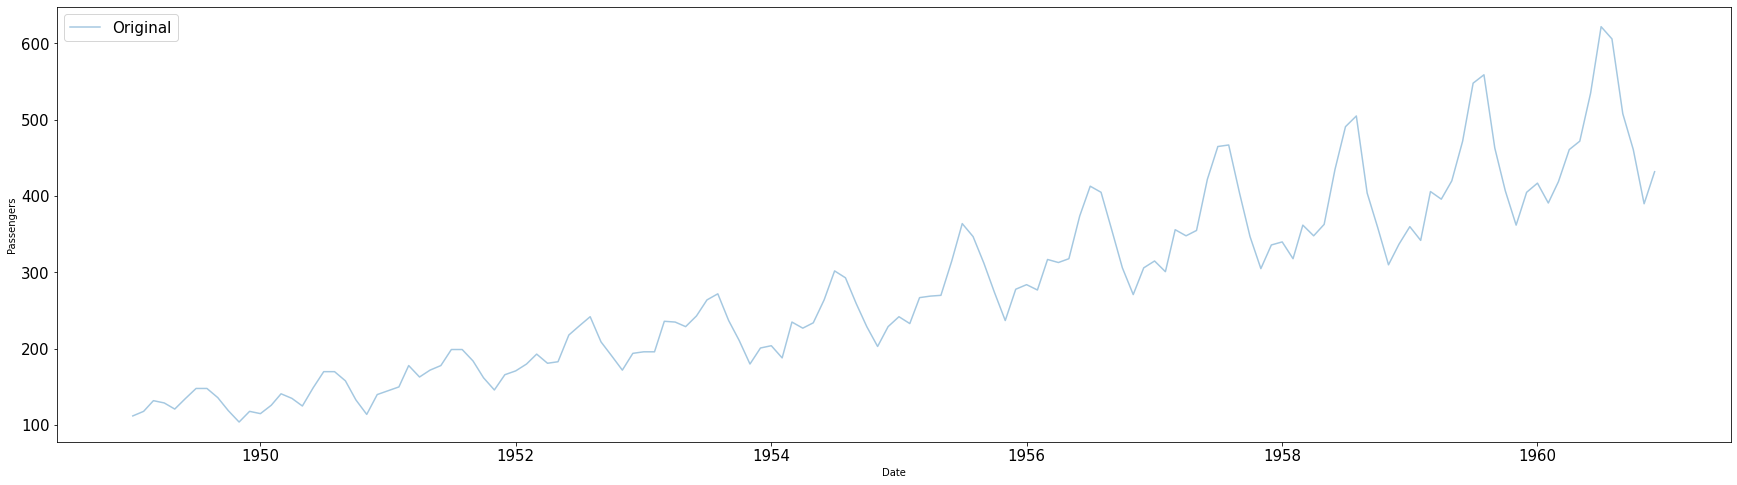

In [60]:
# Plotting Data
plt.figure(figsize=(30,8))

plt.plot(airline['Month'], airline['Passengers'], label='Original', alpha=0.4)
# plt.plot(airline['Month'], airline['3M_MA'], label='7-day Moving Average')
# plt.plot(airline['Month'], airline['3M_STD'], label='7-day Standard Deviation')

plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date')
plt.ylabel('Passengers');

### Perform the time series decompose on the airline data

In [61]:
# your code here

### Perform the ADFuller test on the airline data

In [62]:
# your code here

### What is your conclusion? Is the time series stationary or not stationary?

*write your answer here*

## Bonus: How to make pivot tables!

In some cases, you have the same date, but for different categories (like countries, products, etc.)

One way to easily visualize the data is to create pivot tables!

In [63]:
land_temp = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv')
land_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [64]:
land_temp['dt'] = pd.to_datetime(land_temp['dt'])

Notice that there are a lot of `NaN` values. These are mostly missing data for some countries. Since we do have a lot of data, we can trim the time series.

In [65]:
land_temp.Country.unique()

array(['Åland', 'Afghanistan', 'Africa', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
       'Burkina Faso', 'Burma', 'Burundi', "Côte D'Ivoire", 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Comoros',
       'Congo (Democratic Republic Of The)', 'Congo', 'Costa Rica',
       'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic',
       'Denmark (Europe)', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecu

In [66]:
land_temp_1990 = land_temp[land_temp.dt > '1990-01-01']
land_temp_1990.head(15)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
2955,1990-02-01,3.350,0.629,Åland
2956,1990-03-01,3.134,0.231,Åland
2957,1990-04-01,4.846,0.255,Åland
2958,1990-05-01,8.708,0.378,Åland
2959,1990-06-01,12.595,0.490,Åland
2960,1990-07-01,14.767,0.636,Åland
2961,1990-08-01,16.074,0.427,Åland
2962,1990-09-01,10.533,0.358,Åland
2963,1990-10-01,7.543,0.273,Åland
2964,1990-11-01,2.475,0.236,Åland


In [67]:
land_temp_pivot = pd.pivot_table(land_temp_1990, index='dt', columns='Country', values='AverageTemperature')
land_temp_pivot.head()

Country,Afghanistan,Africa,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua And Barbuda,Argentina,...,Uruguay,Uzbekistan,Venezuela,Vietnam,Virgin Islands,Western Sahara,Yemen,Zambia,Zimbabwe,Åland
dt,,,,,,,,,,,,,,,,,,,,,
1990-02-01,3.669,22.417,7.120,16.059,27.274,9.238,23.477,25.041,24.910,20.844,...,23.284,0.879,25.375,21.093,24.678,21.030,23.741,22.792,23.399,3.350
1990-03-01,8.402,24.013,10.202,19.661,27.371,9.076,23.754,25.617,25.533,18.194,...,20.987,8.003,25.936,22.726,25.220,22.858,25.500,23.187,24.195,3.134
1990-04-01,14.457,25.799,11.753,23.090,26.866,9.071,22.962,26.219,26.168,14.242,...,18.502,13.995,26.175,25.645,25.861,21.593,27.095,22.631,22.362,4.846
1990-05-01,22.442,26.256,16.526,27.491,27.665,15.563,21.865,27.288,27.256,10.831,...,13.951,21.384,25.772,26.198,27.025,23.606,30.508,21.212,19.777,8.708
1990-06-01,26.340,26.427,20.131,33.167,27.177,17.662,20.157,28.060,27.935,8.023,...,10.627,28.027,25.445,27.118,27.933,26.105,31.067,19.590,18.616,12.595


In [68]:
land_temp_pivot.shape

(284, 242)

Since there are over 242 columns (or countries), let us select only the first 10 for the visualization.

In [69]:
land_temp_pivot.iloc[:,0:10]

Country,Afghanistan,Africa,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua And Barbuda,Argentina
dt,,,,,,,,,,
1990-02-01,3.669,22.417,7.120,16.059,27.274,9.238,23.477,25.041,24.910,20.844
1990-03-01,8.402,24.013,10.202,19.661,27.371,9.076,23.754,25.617,25.533,18.194
1990-04-01,14.457,25.799,11.753,23.090,26.866,9.071,22.962,26.219,26.168,14.242
1990-05-01,22.442,26.256,16.526,27.491,27.665,15.563,21.865,27.288,27.256,10.831
1990-06-01,26.340,26.427,20.131,33.167,27.177,17.662,20.157,28.060,27.935,8.023
...,...,...,...,...,...,...,...,...,...,...
2013-05-01,21.355,26.671,18.355,28.482,28.045,11.910,21.861,27.667,27.706,11.745
2013-06-01,26.879,26.324,21.070,32.288,27.650,17.010,20.103,28.414,28.322,9.594
2013-07-01,28.205,25.856,23.591,34.707,26.902,22.003,19.656,28.904,28.712,8.344


<AxesSubplot:xlabel='dt'>

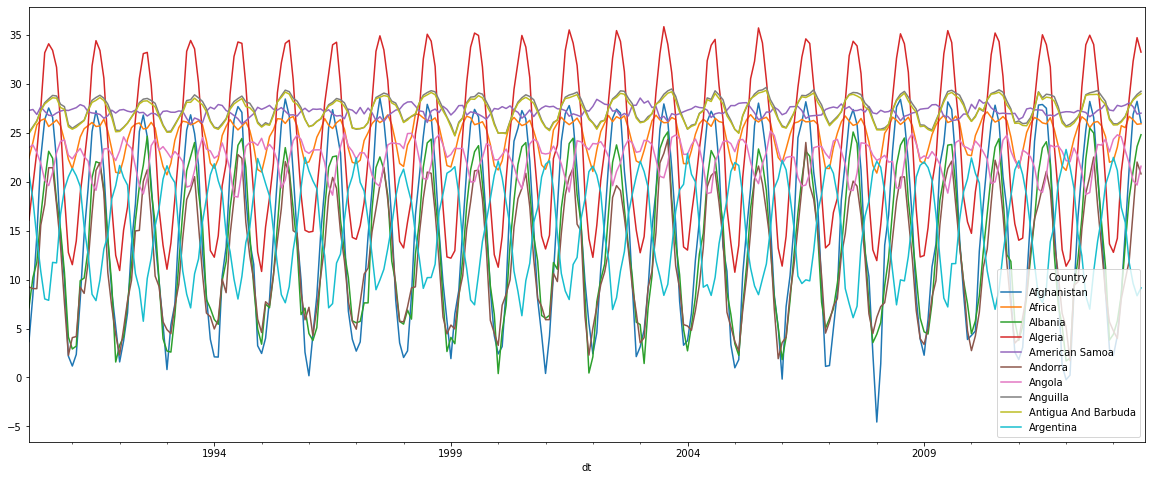

In [70]:
land_temp_pivot.iloc[:,0:10].plot(figsize=(20,8))

<AxesSubplot:xlabel='dt', ylabel='Country'>

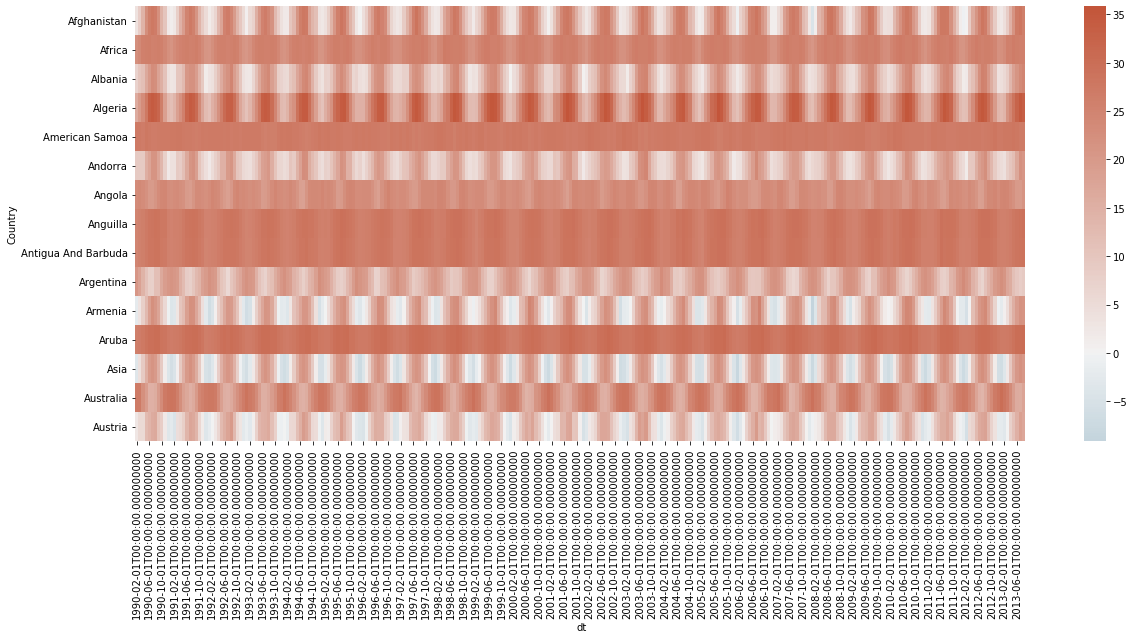

In [71]:
import seaborn as sns

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(land_temp_pivot.iloc[:,0:15].T, ax=ax, center=0, cmap=cmap)

To explain the chart above, we used a diverging color map centered at zero to differentiate the positive and negative values.

The heat map shows the time series using "heat" instead of lines to show the intensity. 

Here, you can als see the repeating patterns of seasonality as seen in the line chart above.